In [24]:
library(tidyverse)
library(caret)

# Generate Simulated Data Set

In [ ]:
library(tidyverse)
library(caret)

In [25]:
## Functions used to generate fake data
set.seed(42)
f_fried <- function(x) 10 * sin(pi * x[,1] * x[,2]) + 20 * (x[,3] - 0.5)^2 + 
  10 * x[,4] + 5 * x[,5]

our_function <- function(x) sin(x[,1])*exp(x[,2])*10 + cos(2*x[,3]) - 20*x[,4]^2 + 3*x[,5]^3 - 15*x[,6]^(1/3) 

high_dimensional_func <- function(x) 10 * sin(pi * apply(x[,1:100], 1, prod)) + 20 * (apply(x[,101:150],1,sum) - 5)^2 + 
  10 * apply(x[,151:200],1,sum) + 5 * apply(x[,201:250],1,sum)

gen_data <- function(n_train, n_test, func, P, sigma, a, b) {
  X <- matrix(runif(n_train * P, a, b), nrow = n_train)
  mu <- func(X)
  X_test <- matrix(runif(n_test * P, a, b), nrow = n_test)
  mu_test <- func(X_test)
  Y <- mu + sigma * rnorm(n_train)
  Y_test <- mu_test + sigma * rnorm(n_test)
  
  return(list(X = X, Y = Y, mu = mu, X_test = X_test, Y_test = Y_test, mu_test = mu_test))
}


## Simiulate dataset
sim_data <- gen_data(250, 100, 5, 1)

ERROR: Error in runif(n_train * P, a, b): argument "a" is missing, with no default


In [4]:
sim_data$X %>% head
sim_data$Y %>% head

0.9148060,0.33423133,0.1365052,0.24492099,0.84829322
0.9370754,0.18843433,0.1771364,0.08763591,0.06274633
0.2861395,0.26971618,0.5195605,0.39110850,0.81984509
0.8304476,0.53074408,0.8111208,0.18256143,0.53936029
0.6417455,0.02145023,0.1153620,0.13362478,0.49902010
0.5190959,0.79876031,0.8934218,0.25746291,0.02222732


[1] 16.554997  7.722252 11.781766 17.247000  6.338875 14.523815

# BART with 5 Predictors

In [22]:
options(java.parameters = "-Xmx8g")
library(bartMachine)

Loading required package: rJava
Loading required package: bartMachineJARs
Loading required package: car
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some

Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: missForest
Loading required package: itertools
Welcome to bartMachine v1.2.3! You have 7.64GB memory available.

If you run out of memory, restart R, and use e.g.
'options(java.parameters = "-Xmx5g")' for 5GB of RAM before you call
'library(bartMachine)'.



In [8]:
#Include the parallel library. If the next line does not work, run install.packages(“parallel”) first
library(parallel)
library(doParallel)

# Use the detectCores() function to find the number of cores in system
n_cores <- detectCores()
print(n_cores)
cl <- makePSOCKcluster(n_cores)
#registerDoParallel(cl)
#stopCluster(cl)

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: iterators


[1] 16


In [24]:
set_bart_machine_num_cores(n_cores)

bartMachine now using 16 cores.


In [47]:
t.start <- Sys.time()
sim.bm <- bartMachine(X = sim_data$X %>% data.frame, y = sim_data$Y,
            verbose = TRUE, 
            serialize =  TRUE)
t.final <- Sys.time() - t.start
print(t.final)

bartMachine now using 16 cores.
bartMachine initializing with 50 trees...
bartMachine vars checked...
bartMachine java init...
bartMachine factors created...
bartMachine before preprocess...
bartMachine after preprocess... 6 total features...
bartMachine sigsq estimated...
bartMachine training data finalized...
Now building bartMachine for regression ...
evaluating in sample data...done
serializing in order to be saved for future R sessions...done
Time difference of 2.383111 secs


In [25]:
k_fold_cv(X = sim_data$X %>% data.frame, y = sim_data$Y,)

.....


$y_hat
  [1] 16.751002  9.003187 10.393871 16.648342  8.088866 15.589679 11.517486
  [8]  9.393314 23.457646 24.651145 21.840740 14.352381 10.640591  7.983101
 [15] 15.039152 15.900753 17.689324  6.633624 18.237390 16.531297 14.256161
 [22]  7.916213 16.662168  9.466571 10.944249  8.241600 19.586498 21.399149
 [29] 19.851707 22.982708 22.283221 10.712727  8.332359 11.607928  9.083424
 [36] 12.748709 11.055056  9.182517 14.501637  2.979342 22.507218 16.849474
 [43]  8.606577 13.966851 13.450231  7.930544 16.945329 16.183754 17.903393
 [50]  3.861381 21.909506 16.248389  4.989257 19.307749 11.725211 18.179739
 [57] 19.252243  7.056124 10.193155 12.496582  6.817788 20.311617 19.459951
 [64] 11.682956 16.294272 14.151845 17.387232 12.870673 11.936840 17.127771
 [71]  6.289218  9.247907 12.442399 13.311603  7.076168 22.776591  8.872989
 [78] 12.767096 12.043291  3.951173 15.642121 14.075679  5.254621 15.873127
 [85] 19.755394 13.606963 15.706155 14.565298 15.131643  4.994866 18.844360
 [92]  9.041348  9.868136 20.145630 10.202334  5.585228 14.257639 10.715617
 [99] 23.603510 14.490610 13.124708 17.101838  8.463148  7.926427 16.615635
[106] 12.135240 20.436471 22.641279 16.793212 14.263697 21.917033 17.220080
[113] 14.894448 14.902353 14.912660 21.267506  8.944323 15.139901 11.378301
[120] 17.778699 13.049821 17.569553 13.744353 13.259052 20.028786 19.355472
[127]  9.895934 12.550233 10.936651 17.451683 20.360241 20.560786 17.979877
[134] 17.101740 19.605001 16.112944  9.436568  4.378012 17.028930 14.591390
[141]  8.857446 14.080849 15.780865 15.273015 14.484511 20.690454  9.335502
[148]  7.343281 19.724527 12.927239  7.763290 11.358088 21.127853 11.670056
[155] 17.778355 17.820344 12.651325  8.105642  9.522261 10.255220 13.172205
[162] 18.002538 15.111509 16.649866 11.092117 11.156617 15.119576 12.479180
[169]  9.257354  4.335815 10.249745 22.175292 26.200557 13.783525 16.572462
[176] 11.383695 14.854206 16.801835 14.151406 19.181305 16.504314 21.886341
[183] 17.361232 15.009564 20.353947  8.760205 14.676098 14.433862  5.520380
[190] 17.250947 12.785918 20.181668  5.496617  9.832297 14.454883  9.065565
[197]  2.524225 14.630450 22.766606  4.302309 16.877538 13.174706 16.516051
[204] 16.915854 11.374320 15.628630 17.351300 20.114019 14.175182 15.828327
[211] 18.747976 15.653779  7.557414 11.157367  7.437625 23.812189  7.638827
[218]  7.552619 18.261435 14.064488 11.715567  9.330249 21.116377 13.653453
[225] 11.247090 15.825774 14.174261  9.427789 10.392989 10.518547 11.111380
[232]  8.513970 15.786873 15.104137 17.613363 15.159522 16.165361 10.988610
[239]  8.486608 12.202136 18.674777 11.627657 14.739673 18.193373 13.758490
[246]  7.891685 15.200271  6.909556 11.873568  7.208827

$L1_err
[1] 287.49

$L2_err
[1] 533.3204

$rmse
[1] 1.460576

$PseudoRsq
[1] 0.9170657

$folds
  [1] 1 2 2 4 4 1 1 3 1 5 3 5 1 1 4 3 1 1 2 2 4 4 3 5 3 5 2 1 1 3 5 5 5 4 3 3 5
 [38] 5 3 2 1 2 1 5 4 1 4 5 4 2 3 1 4 2 5 1 2 4 2 2 2 4 3 2 3 5 4 4 2 3 4 5 3 5
 [75] 5 5 5 3 4 5 2 3 4 1 1 4 1 1 4 4 5 3 3 4 4 2 2 5 5 3 3 4 3 3 4 5 3 1 5 5 2
[112] 1 5 4 5 1 3 2 2 3 3 1 2 1 5 4 4 5 2 2 2 5 4 2 1 1 1 4 3 1 2 2 3 2 2 1 5 5
[149] 2 3 1 2 1 2 1 3 5 3 2 2 1 2 2 1 1 3 5 4 2 1 5 5 4 5 2 1 1 5 2 4 5 3 4 3 5
[186] 3 4 2 1 4 4 3 3 2 5 3 2 4 2 5 3 1 1 2 1 5 4 3 2 1 5 5 3 3 3 3 4 4 4 1 2 4
[223] 5 1 4 4 2 4 4 4 5 2 4 4 3 1 2 1 3 3 3 3 1 5 3 1 5 4 5 1

In [29]:
sim.bm %>% summary

bartMachine v1.2.3 for regression

training data n = 250 and p = 5 
built in 1.8 secs on 16 cores, 50 trees, 250 burn-in and 1000 post. samples

sigsq est for y beforehand: 6.669 
avg sigsq estimate after burn-in: 0.9155 

in-sample statistics:
 L1 = 128.95 
 L2 = 105.62 
 rmse = 0.65 
 Pseudo-Rsq = 0.9836
p-val for shapiro-wilk test of normality of residuals: 0.71078 
p-val for zero-mean noise: 0.35537 



In [39]:
rmse <- function(actual, predicted){
    sqrt(mean((actual-predicted)^2))
}

In [30]:
rmse(sim_data$Y, predict(sim.bm, sim_data$X %>% data.frame)) #insample
rmse(sim_data$Y_test, predict(sim.bm, sim_data$X_test %>% data.frame)) #out of sample

[1] 0.6499761

[1] 1.319237

In [54]:
sim.bm %>% check_bart_error_assumptions

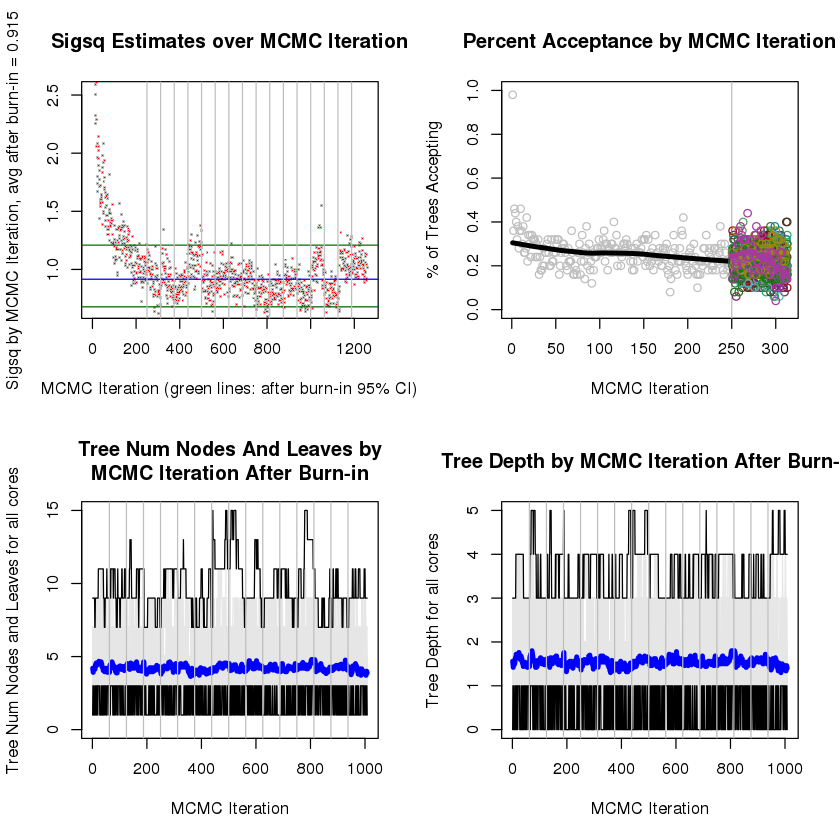

In [53]:
sim.bm %>% plot_convergence_diagnostics

....................


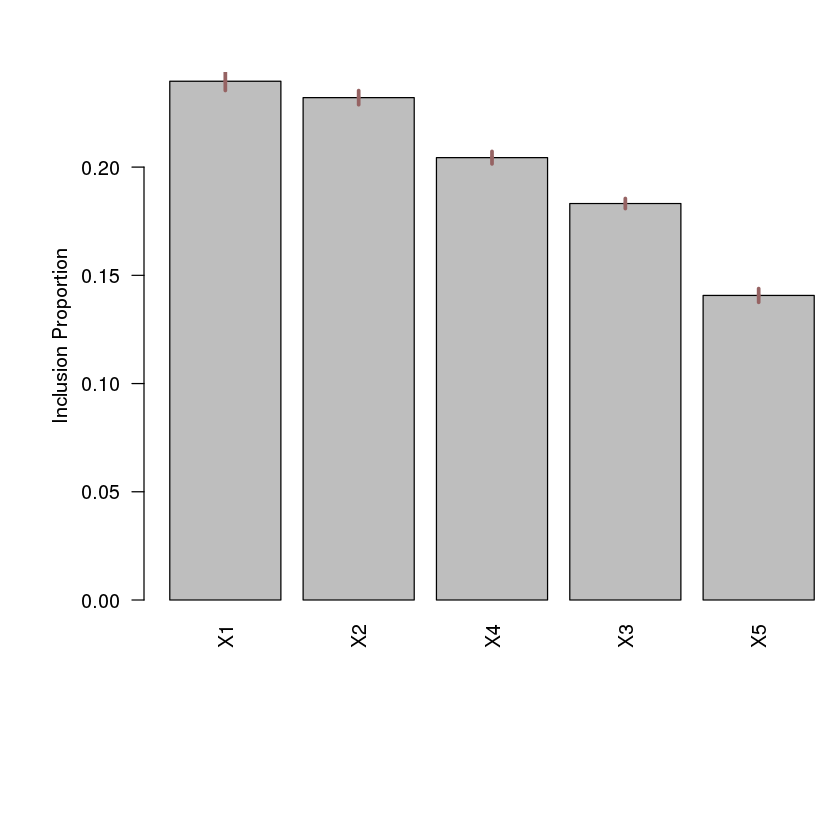

In [31]:
investigate_var_importance(sim.bm, num_replicates_for_avg = 20)

In [28]:
#saveRDS(sim.bm,"model_files/simbm_model_v1_20191124.RDS")
sim.bm.read <- readRDS("model_files/simbm_model_v1_20191124.RDS")
sim.bm <- sim.bm.read

# DART with 5 Predictors

In [1]:
options(java.parameters = "-Xmx8g")
library(dartMachine)

Loading required package: rJava
Loading required package: car
Loading required package: carData
Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: missForest
Loading required package: foreach
Loading required package: itertools
Loading required package: iterators
Welcome to bartMachine v1.2.0! You have 7.64GB memory available.



In [5]:
#Include the parallel library. If the next line does not work, run install.packages(“parallel”) first
library(parallel)
library(doParallel)

# Use the detectCores() function to find the number of cores in system
n_cores <- detectCores()
print(n_cores)
cl <- makePSOCKcluster(n_cores)
#registerDoParallel(cl)
#stopCluster(cl)

[1] 16


In [6]:
set_bart_machine_num_cores(n_cores)

bartMachine now using 16 cores.


In [14]:
t.start <- Sys.time()
sim.dartmachine <- bartMachine(X = sim_data$X %>% data.frame, y = sim_data$Y,
            verbose = TRUE, 
            serialize =  TRUE)
t.final <- Sys.time() - t.start
print(t.final)

bartMachine initializing with 50 trees...
Now building bartMachine for regression ...Covariate importance prior ON. 
evaluating in sample data...done
serializing in order to be saved for future R sessions...done
Time difference of 7.831976 secs


In [9]:
sim.dartmachine %>% summary

bartMachine v1.2.0 for regression

training data n = 250 and p = 5 
built in 7.1 secs on 16 cores, 50 trees, 4000 burn-in and 4000 post. samples

sigsq est for y beforehand: 6.669 
avg sigsq estimate after burn-in: 0.73334 

in-sample statistics:
 L1 = 114.53 
 L2 = 86.78 
 rmse = 0.59 
 Pseudo-Rsq = 0.9865
p-val for shapiro-wilk test of normality of residuals: 0.23902 
p-val for zero-mean noise: 0.19453 



In [15]:
rmse <- function(actual, predicted){
    sqrt(mean((actual-predicted)^2))
}

In [16]:
rmse(sim_data$Y, predict(sim.dartmachine, sim_data$X %>% data.frame)) #insample
rmse(sim_data$Y_test, predict(sim.dartmachine, sim_data$X_test %>% data.frame)) #out of sample

[1] 0.607134

[1] 1.437243

In [17]:
sim.dartmachine %>% check_bart_error_assumptions

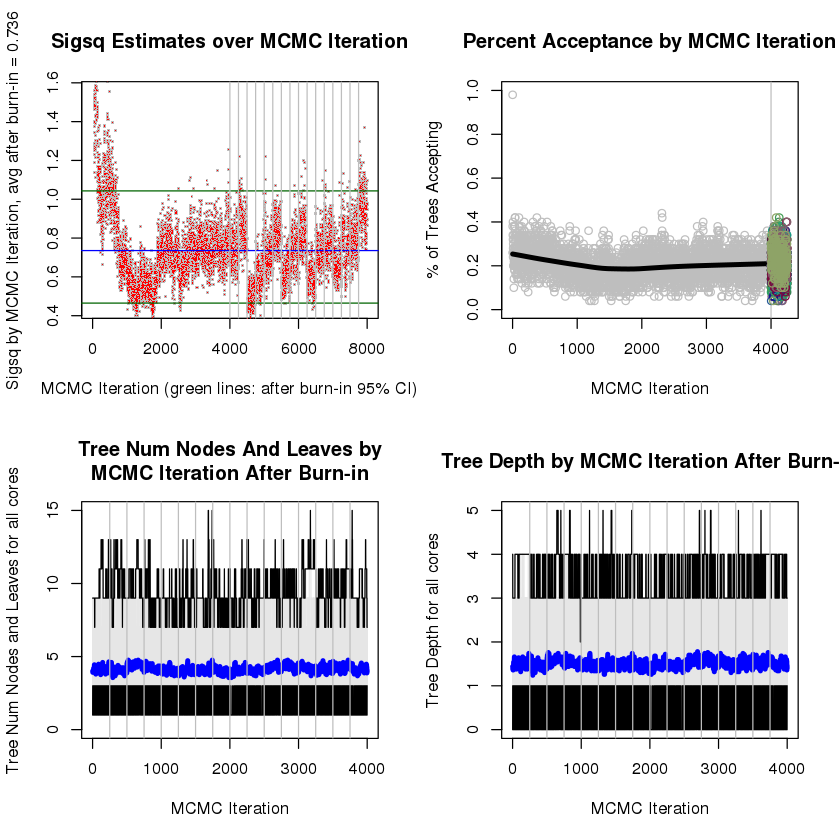

In [18]:
sim.dartmachine %>% plot_convergence_diagnostics

....................


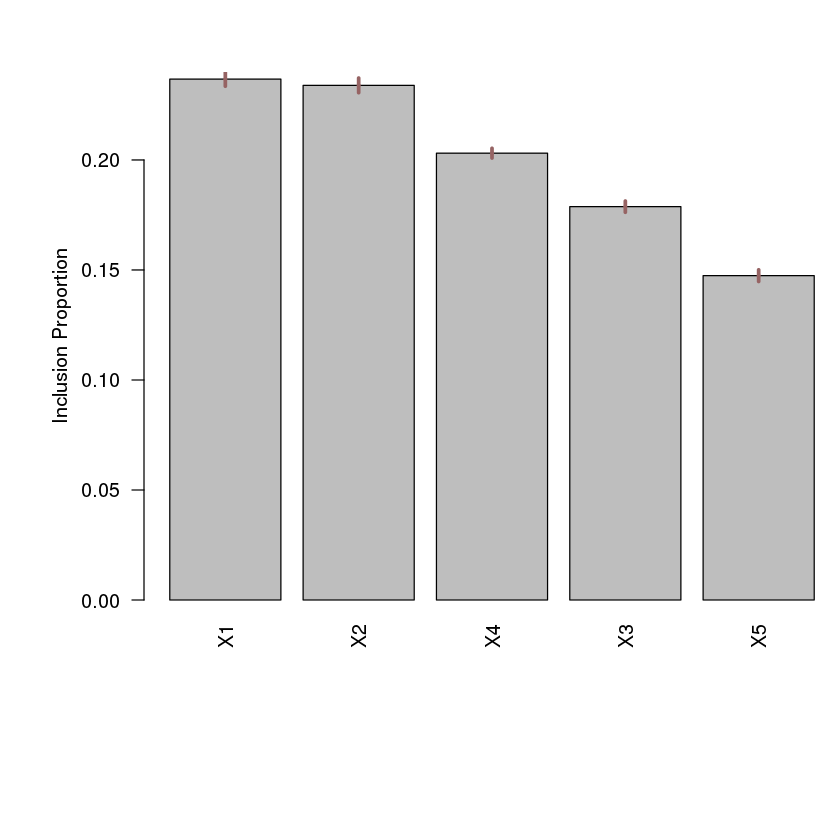

In [19]:
investigate_var_importance(sim.dartmachine, num_replicates_for_avg = 20)

In [20]:
saveRDS(sim.dartmachine,"model_files/simdartMachine_model_v1_20191124.RDS")
sim.dartmachine.read <- readRDS("model_files/simdartMachine_model_v1_20191124.RDS")
sim.dartmachine <- sim.dartmachine.read

# SoftBART

In [1]:
library(SoftBart)

Loading required package: scales
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 3.0-1

Loading required package: Rcpp


Finishing warmup 100 Number of trees = 50
Finishing warmup 200 Number of trees = 50
Finishing warmup 300 Number of trees = 50
Finishing warmup 400 Number of trees = 50
Finishing warmup 500 Number of trees = 50
Finishing warmup 600 Number of trees = 50
Finishing warmup 700 Number of trees = 50
Finishing warmup 800 Number of trees = 50
Finishing warmup 900 Number of trees = 50
Finishing warmup 1000 Number of trees = 50
Finishing warmup 1100 Number of trees = 50
Finishing warmup 1200 Number of trees = 50
Finishing warmup 1300 Number of trees = 50
Finishing warmup 1400 Number of trees = 50
Finishing warmup 1500 Number of trees = 50
Finishing warmup 1600 Number of trees = 50
Finishing warmup 1700 Number of trees = 50
Finishing warmup 1800 Number of trees = 50
Finishing warmup 1900 Number of trees = 50
Finishing warmup 2000 Number of trees = 50
Finishing warmup 2100 Number of trees = 50
Finishing warmup 2200 Number of trees = 50
Finishing warmup 2300 Number of trees = 50
Finishing warmup 240

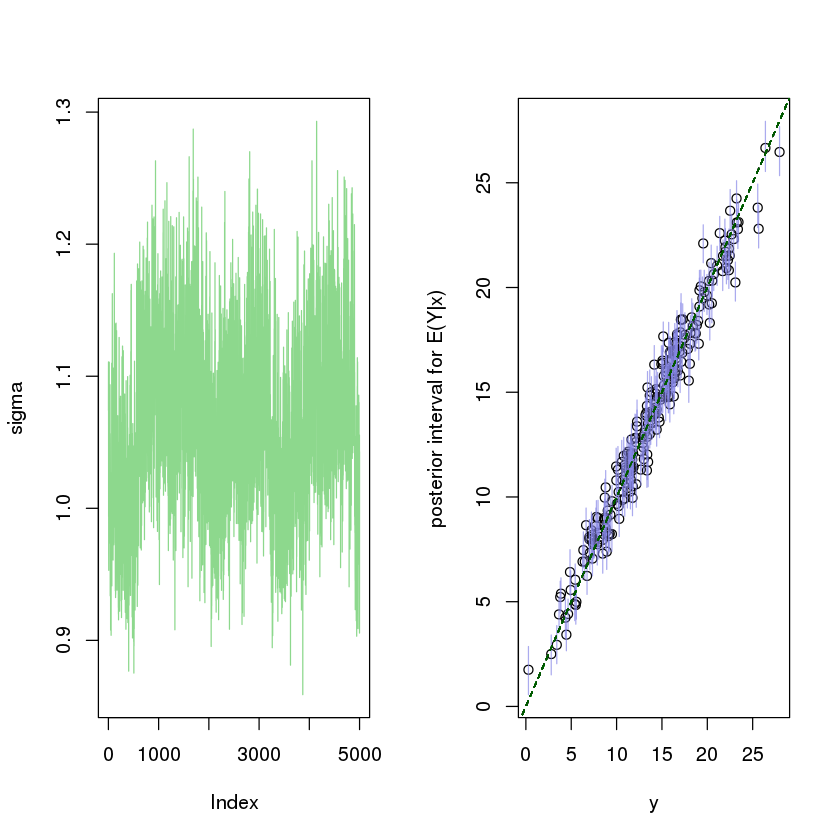

In [9]:
## Fit the models
softbart_fit_1 <- softbart(X = sim_data$X, Y = sim_data$Y, X_test = sim_data$X_test, 
                hypers = Hypers(sim_data$X, sim_data$Y, num_tree = 50, temperature = 1),
                opts = Opts(num_burn = 5000, num_save = 5000, update_tau = TRUE))

plot(softbart_fit_1)

[1] 1.231231

[1] 0.9086065

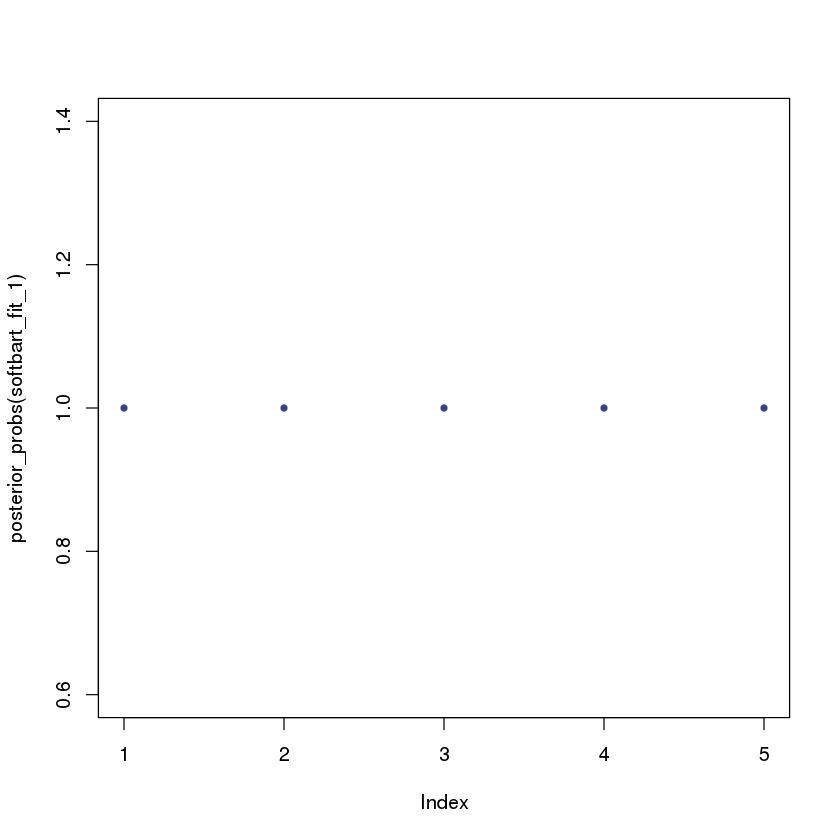

In [13]:
## Look at posterior model inclusion probabilities for each predictor. 

posterior_probs <- function(fit) colMeans(fit$var_counts > 0)
plot(posterior_probs(softbart_fit_1), 
     col = ifelse(posterior_probs(softbart_fit_1) > 0.5, muted("blue"), muted("green")), 
     pch = 20)

rmse <- function(x,y) sqrt(mean((x-y)^2))

In [ ]:
rmse(softbart_fit_1$y_hat_train_mean, sim_data$Y)
rmse(softbart_fit_1$y_hat_test_mean, sim_data$Y_test)

In [19]:
#saveRDS(softbart_fit_1,file = "model_files/softbart_model_20191124.RDS")

In [20]:
softbart_fit_1.read = readRDS("model_files/softbart_model_20191124.RDS")
softbart_fit_1 <- softbart_fit_1.read